## Example: k-Nearest Neighbors

Let's quickly see how we might use this ``argsort`` function along multiple axes to find the nearest neighbors of each point in a set.
We'll start by creating a random set of 10 points on a two-dimensional plane.
Using the standard convention, we'll arrange these in a $10\times 2$ array:

In [4]:
import numpy as np
rand = np.random.RandomState(42)
X = rand.rand(10, 2)

To get an idea of how these points look, let's quickly scatter plot them:

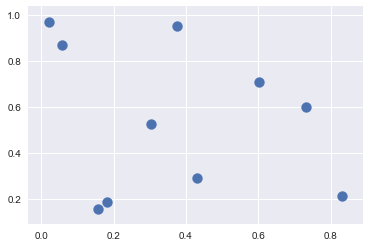

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling
plt.scatter(X[:, 0], X[:, 1], s=100);

Now we'll compute the distance between each pair of points.
Recall that the squared-distance between two points is the sum of the squared differences in each dimension;
using the efficient broadcasting ([Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)) and aggregation ([Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb))  routines provided by NumPy we can compute the matrix of square distances in a single line of code:

In [6]:
dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

This operation has a lot packed into it, and it might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. When you come across code like this, it can be useful to break it down into its component steps:

In [7]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
differences.shape

(10, 10, 2)

In [8]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [9]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

Just to double-check what we are doing, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zero:

In [10]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It checks out!
With the pairwise square-distances converted, we can now use ``np.argsort`` to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [11]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 3 4 5 8 1 9 7 2 6]
 [1 4 6 9 8 0 7 3 2 5]
 [2 7 9 8 6 4 3 1 0 5]
 [3 5 0 8 4 9 7 2 1 6]
 [4 1 0 8 9 6 3 5 7 2]
 [5 3 0 8 4 9 1 7 2 6]
 [6 1 9 4 8 7 2 0 3 5]
 [7 2 9 8 6 4 1 3 0 5]
 [8 9 4 7 2 3 0 1 5 6]
 [9 8 7 2 6 1 4 0 3 5]]


Notice that the first column gives the numbers 0 through 9 in order: this is due to the fact that each point's closest neighbor is itself, as we would expect.

By using a full sort here, we've actually done more work than we need to in this case. If we're simply interested in the nearest $k$ neighbors, all we need is to partition each row so that the smallest $k + 1$ squared distances come first, with larger distances filling the remaining positions of the array. We can do this with the ``np.argpartition`` function:

In [12]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)

In order to visualize this network of neighbors, let's quickly plot the points along with lines representing the connections from each point to its two nearest neighbors:

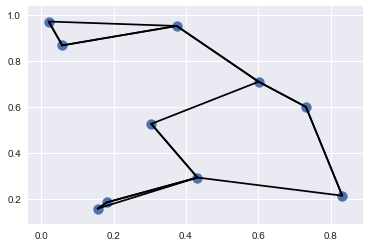

In [13]:
plt.scatter(X[:, 0], X[:, 1], s=100)

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color='black')

Each point in the plot has lines drawn to its two nearest neighbors.
At first glance, it might seem strange that some of the points have more than two lines coming out of them: this is due to the fact that if point A is one of the two nearest neighbors of point B, this does not necessarily imply that point B is one of the two nearest neighbors of point A.

Although the broadcasting and row-wise sorting of this approach might seem less straightforward than writing a loop, it turns out to be a very efficient way of operating on this data in Python.
You might be tempted to do the same type of operation by manually looping through the data and sorting each set of neighbors individually, but this would almost certainly lead to a slower algorithm than the vectorized version we used. The beauty of this approach is that it's written in a way that's agnostic to the size of the input data: we could just as easily compute the neighbors among 100 or 1,000,000 points in any number of dimensions, and the code would look the same.

Finally, I'll note that when doing very large nearest neighbor searches, there are tree-based and/or approximate algorithms that can scale as $\mathcal{O}[N\log N]$ or better rather than the $\mathcal{O}[N^2]$ of the brute-force algorithm. One example of this is the KD-Tree, [implemented in Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html).